# Intro to GIS with Python
## What is GIS?
GIS stands for _geographic information system_. Colloquially, it's the process of presenting and analyzing data on maps. GIS allows us to visualize and characterize the nature of spatially distributed data, including weather, infrastructure, and populations. As you can imagine, this is key for disaster response scenarios for both diagnosing the situation, as well as planning and monitoring the response.

There are dozens of different GIS software options, both free and commercial. In this course, we will focus on free, python-based tools and packages. The principles taught in this course should carry over to most common GIS implementations. 

In particular, we will be using:
- GDAL
- geopandas

This content is based off of the [Automating GIS Processes course](https://automating-gis-processes.github.io/2018/) from the University of Helsinki

In [3]:
try: # try the following block of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd
  
try:
  import contextily as ctx # import
except:
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
import contextily as ctx # library for providing background maps
import fiona # library for reading/writing GIS files, comes w/ geopandas
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt

## Reading in GIS data
For this lesson we are using data in Shapefile format representing distributions of specific beautifully colored fish species called Damselfish and the country borders of Europe.

We're going to use the `wget` terminal command to download a file from a url.
We then use `unzip` to unzip the archive into a folder of the same name. The `-o` option is used to overwrite the folder if it already exists
We then us `ls` to see the contents of the folder

In [2]:
!wget https://github.com/Automating-GIS-processes/Lesson-2-Geo-DataFrames/raw/master/data/Data.zip -O fish_data.zip
!unzip -o fish_data.zip 
!ls L2_data

--2020-07-13 14:01:32--  https://github.com/Automating-GIS-processes/Lesson-2-Geo-DataFrames/raw/master/data/Data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Automating-GIS-processes/Lesson-2-Geo-DataFrames/master/data/Data.zip [following]
--2020-07-13 14:01:32--  https://raw.githubusercontent.com/Automating-GIS-processes/Lesson-2-Geo-DataFrames/master/data/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12436106 (12M) [application/zip]
Saving to: ‘fish_data.zip’

fish_data.zip       100%[===================>]  11.86M  24.3MB/s    in 0.5s    

2020-07-13 14:01:33 (24.3 MB/s) - ‘fish_data.zip’ saved [12436106/12436106

Typically reading the data into Python is the first step of the analysis pipeline. In GIS, there exists various dataformats such as [Shapefile](https://en.wikipedia.org/wiki/Shapefile), [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON), [KML](https://en.wikipedia.org/wiki/Keyhole_Markup_Language), and [GPKG](https://en.wikipedia.org/wiki/GeoPackage) that are probably the most common vector data formats. Geopandas is capable of reading data from all of these formats (plus many more). Reading spatial data can be done easily with geopandas using `gpd.from_file()` -function:

In [3]:
# path to shapefile
filepath = "Data/DAMSELFISH_distributions.shp"

# Read file using gpd.read_file()
data = gpd.read_file(filepath)

In [4]:
ctx.add_basemap(ax)

NameError: name 'ax' is not defined

In [4]:
data.head() #look at top entries - looks like a pandas dataframe

,ID_NO,BINOMIAL,ORIGIN,COMPILER,YEAR,CITATION,SOURCE,DIST_COMM,ISLAND,SUBSPECIES,...,RL_UPDATE,KINGDOM_NA,PHYLUM_NAM,CLASS_NAME,ORDER_NAME,FAMILY_NAM,GENUS_NAME,SPECIES_NA,CATEGORY,geometry
0,183963.0,Stegastes leucorus,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,...,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Stegastes,leucorus,VU,"POLYGON ((-115.64375 29.71392, -115.61585 29.6..."
1,183963.0,Stegastes leucorus,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,...,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Stegastes,leucorus,VU,"POLYGON ((-105.58995 21.89340, -105.56483 21.8..."
2,183963.0,Stegastes leucorus,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,...,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Stegastes,leucorus,VU,"POLYGON ((-111.15962 19.01536, -111.15948 18.9..."
3,183793.0,Chromis intercrusma,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,...,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,intercrusma,LC,"POLYGON ((-80.86500 -0.77894, -80.75930 -0.833..."
4,183793.0,Chromis intercrusma,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,...,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,intercrusma,LC,"POLYGON ((-67.33922 -55.67610, -67.33755 -55.6..."


In [5]:
# Note the column 'geometry' is full of shapely Polygon objects
type(data['geometry'].iloc[0])

shapely.geometry.polygon.Polygon

In [6]:
# geopandas adds useful attributes to the geodataframe, such as the ability to get bounds
# of all the geometry data
data.bounds

,minx,miny,maxx,maxy
0,-116.222084,21.890988,-108.497261,29.767482
1,-107.594206,18.358633,-103.606827,22.256010
2,-112.956729,18.045856,-111.159482,19.956861
3,-82.225059,-57.388035,-67.241505,-0.692622
4,-67.356079,-55.719820,-67.318440,-55.663008
...,...,...,...,...
226,-120.491194,31.735737,-117.143276,34.476475
227,-119.352264,27.831807,-117.397705,30.225376
228,-116.439015,27.239447,-114.631652,29.299307
229,-112.956729,18.045856,-111.159482,19.956861


In [7]:
# similary, we can get attributes such as boundary
data.boundary

0      MULTILINESTRING ((-115.64375 29.71392, -115.61...
1      MULTILINESTRING ((-105.58995 21.89340, -105.56...
2      MULTILINESTRING ((-111.15962 19.01536, -111.15...
3      MULTILINESTRING ((-80.86500 -0.77894, -80.7593...
4      LINESTRING (-67.33922 -55.67610, -67.33755 -55...
                             ...                        
226    MULTILINESTRING ((-120.11829 34.47283, -120.10...
227    MULTILINESTRING ((-117.41363 29.18823, -117.40...
228    MULTILINESTRING ((-114.63839 28.39008, -114.63...
229    MULTILINESTRING ((-111.15962 19.01536, -111.15...
230    LINESTRING (-114.24428 22.71135, -114.24818 22...
Length: 231, dtype: geometry

In [8]:
# area
data.area

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


0      19.396254
1       6.145902
2       2.697207
3      87.460621
4       0.000918
         ...    
226     5.990467
227     3.638651
228     2.849025
229     2.697207
230     2.237186
Length: 231, dtype: float64

In [9]:
# we can check which species can be found between latitudes 10 and 20 degrees north
data.intersects(Polygon([(-180,10),(180,10),(180,20),(-180,20)]))

0      False
1       True
2       True
3      False
4      False
       ...  
226    False
227    False
228    False
229     True
230    False
Length: 231, dtype: bool

## Exercises
Using the polygon objects in the `geometry` column of the data frame:
- create a new column called `area` which represent the areas of each row in the shapefile
- What are the max, min, median, and quartiles values of the areas?
- What fraction of the areas are greater than 25 square degrees?
- What species has the largest total area?

In [10]:
data['area'] = data.area
data = data.sort_values('area', ascending=True)

maximum = data.iloc[-1, -1]
minimum = data.iloc[0, -1]
median = data.iloc[len(data)//2, -1]
quartile1 = data.iloc[len(data)//4, -1]
quartile3 = data.iloc[len(data) * 3//4, -1]

count = 0
for i in range(0, len(data)):
    if data.iloc[i, -1] > 25:
        count += 1
fraction = count / len(data)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


## Plotting
Geopandas provides a useful `.plot()`  function which creates a matplotlib figure and returns an axes object.

There's a ton of additional libraries that provide more plotting functionality, and we'll explore a few of them here. There's no "correct" set of libraries to use for GIS in python, and it's up to you to figure out which ones fit the best into your workflow.

The `cmap` option to the `.plot()` function allows you to pass in a [matplotlib colormap name](https://matplotlib.org/gallery/color/colormap_reference.html), which are collections of colors used to visualize data

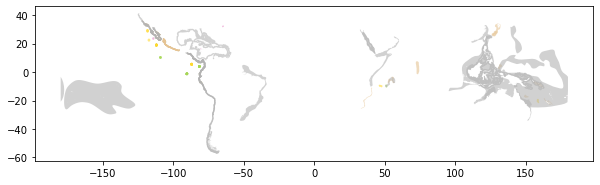

In [11]:
# we can use the built-in geopandas plot function to visualize
ax = data.plot(figsize=(10,5), alpha=0.6, cmap='Set2')

currently the colors are assigned arbitrarily. However, we can also use colors to encode information. 

Let's first use colors to categorize by endangerment status. To do so, we pass the `column` argument to `plot()`. For reference, we also set `legend=True`

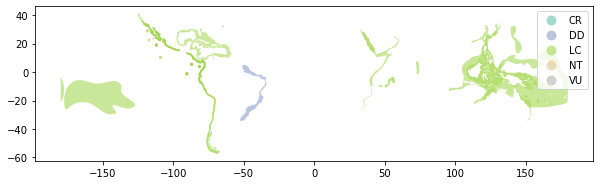

In [12]:
ax = data.plot(figsize=(10,5), alpha=0.6, cmap='Set2', column='CATEGORY', legend=True)

Another common use of colors to encode data is to represent numerical data in an area with colors. This is known as a [choropleth](https://en.wikipedia.org/wiki/Choropleth_map).

Let's use this to encode the areas of each region

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


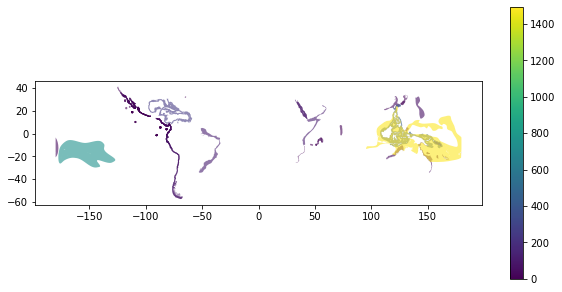

In [13]:
#first create a column of areas
data['area'] = data.area

#then pass the area column as an argument
ax = data.plot(figsize=(10,5), alpha=0.6, column='area', legend=True)

The colorbar legend is too big relative to the figure. We'll have to do some manual adjustments. There are tools to create axes grids for colorbars available in:
https://matplotlib.org/3.1.0/tutorials/toolkits/axes_grid.html

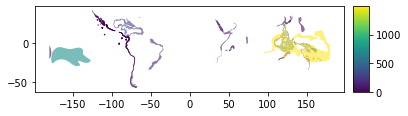

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax) #makes it so you can append to the axes

#put another axes to the right of it, at 5% of the total width with 0.1 points of padding in between
cax = divider.append_axes("right", size="5%", pad=0.1) 
# note that you have to specify both ax and cax as arguments for it to work
data.plot(figsize=(10,5), alpha=0.6, column='area', 
          legend=True, ax=ax, cax=cax)

The data by itself looks just like a bunch of blobs. Let's put it on a map for context

GeoDataFrame has an attribute called `.crs` that shows the coordinate system of the data which is empty (None) in our case since we are creating the data from the scratch. 

We will not go into depth about projections, which are a deep topic in and of themselves. For reference, see [this lecture](https://automating-gis-processes.github.io/2018/notebooks/L2/projections.html) from the University of Helsinki Automating GIS Processes course. In short, there are many ways to flatten the globe, each with its own benefits and issues. 

Two of the common ones we'll be using are [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection), which is common in web applications, and [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System), which is the reference coordinate system used by GPS. Each has a EPSG (European Petroleum Survey Group) code associated with it. Web Mercator is EPSG 3857, and WGS84 is 4326.

[Contextily](https://github.com/darribas/contextily) is a library for creating basemaps. It pulls the data from [OpenStreetMap](https://www.openstreetmap.org), a free and excellent wiki google-maps-style service.


In [2]:
# the data is currently in WGS84
data.crs

NameError: name 'data' is not defined

In [1]:
data

NameError: name 'data' is not defined

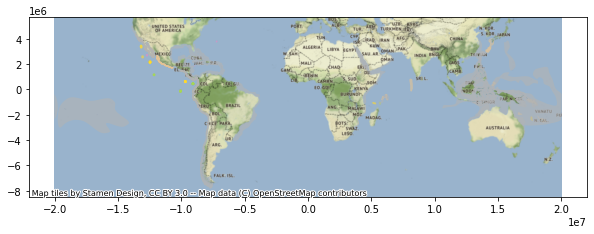

In [16]:
ax = data.to_crs(epsg=3857).plot(figsize=(10,5), alpha=0.6, cmap='Set2')
# now we add a basemap. ctx finds a basemap for a background from
# an online repository
ctx.add_basemap(ax)

We can use different background styles:
![tile styles](https://raw.githubusercontent.com/darribas/contextily/master/tiles.png).

Note that some styles only contain labels or lines.

In [17]:
sources = [i for i in dir(ctx.tile_providers) if i[0]!='_']
sources

['deprecated_sources', 'sys', 'warnings']

In [18]:
# we can get the urls for the different backgrounds using:
getattr(ctx.sources,'ST_TONER_BACKGROUND')
# we'll pass this into the add_basemap function in the url argument

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  


'http://tile.stamen.com/toner-background/{z}/{x}/{y}.png'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  


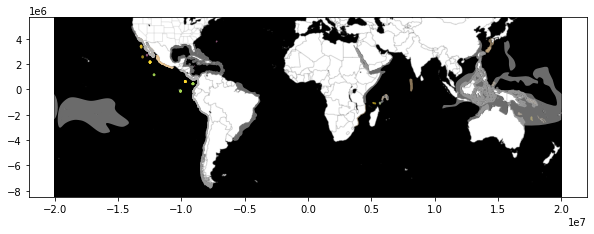

In [19]:
ax = data.to_crs(epsg=3857).plot(figsize=(10,5), alpha=0.6, cmap='Set2')
ctx.add_basemap(ax, url=getattr(ctx.sources,'ST_TONER_BACKGROUND'))

In [20]:
# we can download background tiles as images for quicker loading (don't need to keep redownloading)
# let's use the bounds of one of the fish locations as an example
w,s,e,n = data.loc[25,'geometry'].bounds
data.loc[10,'geometry'].bounds

(-79.56737515199995, 8.442261236000036, -78.48675787199994, 9.030436516000066)

the function bounds2img takes coordinates and [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) and downloads the corresponding tiles of the map as images

[(2498442.0929655433, 2884399.3464440173),
 (-12544723.739110544, -12090944.453255981)]

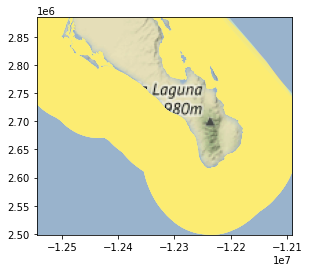

In [21]:
img, ext = ctx.bounds2img(w, s, e, n, 6, ll=True) #ll means coordinates are in lat-lon
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img, extent=ext)
data.to_crs(epsg=3857).plot(ax=ax, cmap='Set3', alpha=0.8)
ax_bounds = data.to_crs(epsg=3857).loc[25,'geometry'].bounds
ax.set(xlim=[ax_bounds[0],ax_bounds[2]],ylim=[ax_bounds[1],ax_bounds[3]])


## Writing to a shapefile

First we'll make a directory for outputting data to. We use the `mkdir` command which makes an empty folder. The `-p` option will skip it if the directory already exists

In [22]:
!mkdir output_data -p

In [23]:
# let's write the first 50 rows of the shapefile to a new file
outfp = "output_data/DAMSELFISH_distributions_SELECTION.shp"

# Select first 50 rows
selection = data[0:50]

# Write those rows into a new Shapefile (the default output file format is Shapefile)
selection.to_file(outfp)

## Converting shapes to GeoDataFrames
You can use Shapely geometric objects to create a GeoDataFrame from scratch. 

In [24]:
# Create an empty geopandas GeoDataFrame
newdata = gpd.GeoDataFrame()

# add a geometry column (necessary for shapefile)
newdata['geometry'] = None

# Let's see what we have at the moment
print(newdata)

Empty GeoDataFrame
Columns: [geometry]
Index: []


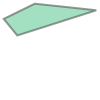

In [25]:
# Coordinates of the MIT main campus in Decimal Degrees
coordinates = [(-71.092562, 42.357602), ( -71.080155, 42.361553), ( -71.089817, 42.362584), (-71.094688, 42.360198)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# Let's see what we have
poly

Quick checkpoint! Find the coordinates of the corners of a place that has significant meaning to you. Just like we did above, make a Shapely polygon from the coordinate-tuple list of the corners of your personal landmark.
Display it! It can be as big as you want. If you want, share out with the class the place and why it is significant to you.  

In [26]:
# Coordinates of place of signficance in Decimal Degrees
coordinates_personal =[]

# Create a Shapely polygon from the coordinate-tuple list
poly_personal =Polygon

#Show the place and share out its significance if you want


In [27]:
# Insert the polygon into 'geometry' -column at index 0
newdata.loc[0, 'geometry'] = poly
newdata

,geometry
0,"POLYGON ((-71.09256 42.35760, -71.08016 42.361..."


In [28]:
newdata.loc[0, 'location'] = 'MIT main campus'
newdata

,geometry,location
0,"POLYGON ((-71.09256 42.35760, -71.08016 42.361...",MIT main campus


Before exporting the data it is necessary to set the coordinate reference system (projection) for the GeoDataFrame. 

We will set the crs using a function from `fiona`, another GIS library integrated with geopandas. 

In [29]:
from fiona.crs import from_epsg

# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
newdata.crs = from_epsg(4326)

# Let's see how the crs definition looks like
print(newdata.crs)

+init=epsg:4326 +no_defs +type=crs


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [30]:
outfp = "output_data/MIT_campus.shp"

# Write the data into that Shapefile
newdata.to_file(outfp)

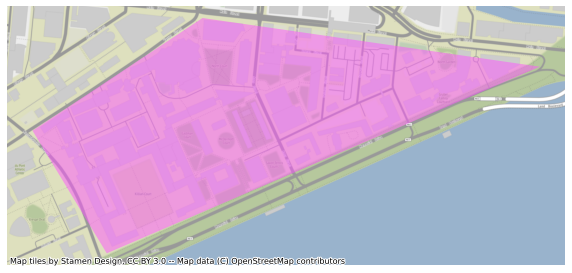

In [31]:
# Let's plot it
ax = newdata.to_crs(epsg=3857).plot(figsize=(10,5),alpha = 0.5, color='#FF55FF')
ctx.add_basemap(ax)
ax.set_axis_off() # remove the x-y axes

# Exercise
Find an interesting GIS dataset and:
- visualize some raw data
- ask an interesting analysis question about it:
  - intersections, sizes, quantities
  - relationships
  - e.g. which latitudes contain the most endangered species? what countries have the most ports per km of coastline?
- Visualize some of your analysis

As per usual, we'll ask a few volunteers to present their results.

Here are some resources to look for GIS datasets:
- Cambridge, MA GIS data: http://cambridgegis.github.io/gisdata.html
- Free GIS data: https://freegisdata.rtwilson.com/
- Data.gov: https://www.data.gov/

NameError: name 'PolygonPatch' is not defined

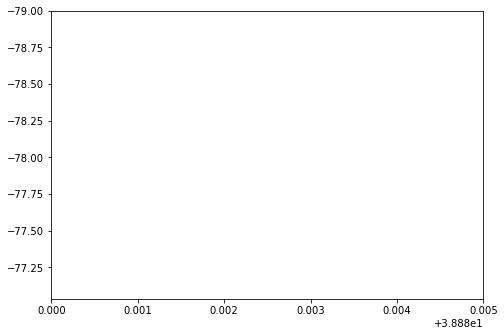

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set(xlim=(38.88, 38.885), ylim=(-77.035146, -79))
# Coordinates of the MIT main campus in Decimal Degrees
       
coordinates = [(38.889550, -77.035345), (38.889550, -77.035146), ( 38.889398, -77.035147), (38.889400, -77.035344)]
coordinates1 = [(38.889504, -77.035296), (38.889507, -77.035194), ( 38.889430, -77.035196), (38.889436, -77.035298)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
poly2 = Polygon(coordinates1)
patch = PolygonPatch(poly.difference(poly2), fc='#FF6600', ec='black', alpha=0.8, linewidth=2)
ax.add_patch(patch)
       

In [ ]:
import shapely
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch # will be used to visualize polygons

An important part responsibility of GIS engineers during the pandemic is to visualize spread and case intensity during the pandemic. Using datasets from the following sources:


*   Visualize raw data collected from sources around the world about the state of the pandemic
*   Explore connections between various factors and come up with a hypothesis for your research. Some ideas could be connecting COVID data in different counties to socioeconomy, age, or building architecture data. Remember, mapping data speaks louder than graphs or datasets.
*   Present your findings to the rest of the class and come up with a possible solution to the problem or connection that you explored

COVID-19 Datasets:
* COVID-19 Dataset (Kaggle): www.kaggle.com/imdevskp/corona-virus-report
* New York Times Dataset: https://github.com/nytimes/covid-19-data
* JHU Dataset: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
*  Feel free to explore more area specific datasets or datasets which outline other conditions. These are just suggestions.

To make your research connections, be sure to explore population and demographic datasets of different counties around the country. Be creative with your research!

In [33]:
import pandas as pd


In [34]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt


Map a shape of your hometown onto the map. Similar to how we mapped the coordinates of the MIT campus on a map, map the coordinates of your hometown onto a map. It doesn't have to exact, but just take a couple rough coordinates and visualize your place on the map. The TAs will try to map these shapes onto a full map so that we can get an idea of where everyone is from and visualize how geographically diverse our class is.

In [35]:
geocode = pd.read_csv('zip_codes_states.csv')

In [36]:
geocode


,zip_code,latitude,longitude,city,state,county
0,501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,602,18.393103,-67.180953,Aguada,PR,Aguada
4,603,18.455913,-67.145780,Aguadilla,PR,Aguadilla
...,...,...,...,...,...,...
42736,99926,55.094325,-131.566827,Metlakatla,AK,Prince Wales Ketchikan
42737,99927,55.517921,-132.003244,Point Baker,AK,Prince Wales Ketchikan
42738,99928,55.395359,-131.675370,Ward Cove,AK,Ketchikan Gateway
42739,99929,56.449893,-132.364407,Wrangell,AK,Wrangell Petersburg


In [37]:
geocode= geocode.drop(columns=['zip_code', 'city', 'state'])

In [38]:
geocode = geocode.sort_values(['county'], ascending = True )

In [39]:
geocode = geocode.dropna()

In [40]:

geocode

,latitude,longitude,county
12663,34.215714,-82.446307,Abbeville
12700,34.221282,-82.631810,Abbeville
12680,34.326755,-82.430787,Abbeville
12679,34.330362,-82.336693,Abbeville
12671,34.191846,-82.490284,Abbeville
...,...,...,...
34945,28.693810,-99.824936,Zavala
34959,28.943649,-99.843874,Zavala
25498,44.992051,-101.568656,Ziebach
25499,45.050456,-101.607171,Ziebach


In [41]:
county = pd.read_csv('Covid.csv')

In [42]:
county = county.sort_values('Cases', ascending = False)
county

,Date,county,State,FIPS,Cases,Death
1828,7/11/2020,New York City,New York,NaN,223382,22750
203,7/11/2020,Los Angeles,California,6037.0,130242,3793
606,7/11/2020,Cook,Illinois,17031.0,95138,4711
101,7/11/2020,Maricopa,Arizona,4013.0,78481,1093
359,7/11/2020,Miami-Dade,Florida,12086.0,60867,1132
...,...,...,...,...,...,...
2185,7/11/2020,Grant,Oregon,41023.0,1,0
1672,7/11/2020,Harlan,Nebraska,31083.0,1,0
2759,7/11/2020,Unknown,Utah,NaN,0,13
1209,7/11/2020,Unknown,Maryland,NaN,0,18


In [43]:
county['Case/Death Ratio'] = county['Death']/county['Cases']


In [44]:
Max = county['Case/Death Ratio'].idxmax()
Max

2759

In [45]:
county.sort_values('Case/Death Ratio', ascending = False)
        
        
        

,Date,county,State,FIPS,Cases,Death,Case/Death Ratio
2480,7/11/2020,Unknown,Tennessee,NaN,0,1,inf
1209,7/11/2020,Unknown,Maryland,NaN,0,18,inf
2759,7/11/2020,Unknown,Utah,NaN,0,13,inf
2004,7/11/2020,Unknown,North Dakota,NaN,4,4,1.000000
1162,7/11/2020,Unknown,Louisiana,NaN,112,108,0.964286
...,...,...,...,...,...,...,...
2048,7/11/2020,Jackson,Ohio,39079.0,28,0,0.000000
3082,7/11/2020,Converse,Wyoming,56009.0,28,0,0.000000
1066,7/11/2020,McLean,Kentucky,21149.0,28,0,0.000000
1625,7/11/2020,Richland,Montana,30083.0,28,0,0.000000


In [46]:
covid19 = county.merge(geocode, how='left')
covid19 = covid19.dropna()

In [47]:
covid19

,Date,county,State,FIPS,Cases,Death,Case/Death Ratio,latitude,longitude
1,7/11/2020,Los Angeles,California,6037.0,130242,3793,0.029123,33.786594,-118.298662
2,7/11/2020,Los Angeles,California,6037.0,130242,3793,0.029123,33.786594,-118.298662
3,7/11/2020,Los Angeles,California,6037.0,130242,3793,0.029123,33.786594,-118.298662
4,7/11/2020,Los Angeles,California,6037.0,130242,3793,0.029123,33.786594,-118.298662
5,7/11/2020,Los Angeles,California,6037.0,130242,3793,0.029123,33.786594,-118.298662
...,...,...,...,...,...,...,...,...,...
188564,7/11/2020,Harlan,Nebraska,31083.0,1,0,0.000000,40.176513,-99.404864
188565,7/11/2020,Harlan,Nebraska,31083.0,1,0,0.000000,40.176513,-99.404864
188566,7/11/2020,Harlan,Nebraska,31083.0,1,0,0.000000,36.817164,-83.419056
188567,7/11/2020,Harlan,Nebraska,31083.0,1,0,0.000000,36.839806,-83.223251


In [48]:

covid19 = covid19.drop(columns=['FIPS', 'State','Case/Death Ratio'])

In [49]:
covid19

,Date,county,Cases,Death,latitude,longitude
1,7/11/2020,Los Angeles,130242,3793,33.786594,-118.298662
2,7/11/2020,Los Angeles,130242,3793,33.786594,-118.298662
3,7/11/2020,Los Angeles,130242,3793,33.786594,-118.298662
4,7/11/2020,Los Angeles,130242,3793,33.786594,-118.298662
5,7/11/2020,Los Angeles,130242,3793,33.786594,-118.298662
...,...,...,...,...,...,...
188564,7/11/2020,Harlan,1,0,40.176513,-99.404864
188565,7/11/2020,Harlan,1,0,40.176513,-99.404864
188566,7/11/2020,Harlan,1,0,36.817164,-83.419056
188567,7/11/2020,Harlan,1,0,36.839806,-83.223251


In [50]:
covid19['latitude'] = round(covid19['latitude'])
covid19['longitude'] = round(covid19['longitude'])

In [51]:
covid19

,Date,county,Cases,Death,latitude,longitude
1,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
2,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
3,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
4,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
5,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
...,...,...,...,...,...,...
188564,7/11/2020,Harlan,1,0,40.0,-99.0
188565,7/11/2020,Harlan,1,0,40.0,-99.0
188566,7/11/2020,Harlan,1,0,37.0,-83.0
188567,7/11/2020,Harlan,1,0,37.0,-83.0


In [54]:
covid19

,Date,county,Cases,Death,latitude,longitude
1,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
2,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
3,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
4,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
5,7/11/2020,Los Angeles,130242,3793,34.0,-118.0
...,...,...,...,...,...,...
188564,7/11/2020,Harlan,1,0,40.0,-99.0
188565,7/11/2020,Harlan,1,0,40.0,-99.0
188566,7/11/2020,Harlan,1,0,37.0,-83.0
188567,7/11/2020,Harlan,1,0,37.0,-83.0


In [55]:
covid19_1 = geopandas.GeoDataFrame(
    covid19, geometry=geopandas.points_from_xy(covid19.longitude, covid19.latitude))

In [56]:
covid19 = covid19.sort_values('Cases', ascending= False)
covid19 = covid19.dropna()

In [57]:
covid19

,Date,county,Cases,Death,latitude,longitude,geometry
1,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
350,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
364,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
363,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
362,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
...,...,...,...,...,...,...,...
187200,7/11/2020,Washington,1,0,41.0,-96.0,POINT (-96.00000 41.00000)
187199,7/11/2020,Washington,1,0,42.0,-96.0,POINT (-96.00000 42.00000)
187198,7/11/2020,Washington,1,0,41.0,-71.0,POINT (-71.00000 41.00000)
187197,7/11/2020,Washington,1,0,41.0,-72.0,POINT (-72.00000 41.00000)


In [58]:
covid19_1


,Date,county,Cases,Death,latitude,longitude,geometry
1,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
2,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
3,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
4,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
5,7/11/2020,Los Angeles,130242,3793,34.0,-118.0,POINT (-118.00000 34.00000)
...,...,...,...,...,...,...,...
188564,7/11/2020,Harlan,1,0,40.0,-99.0,POINT (-99.00000 40.00000)
188565,7/11/2020,Harlan,1,0,40.0,-99.0,POINT (-99.00000 40.00000)
188566,7/11/2020,Harlan,1,0,37.0,-83.0,POINT (-83.00000 37.00000)
188567,7/11/2020,Harlan,1,0,37.0,-83.0,POINT (-83.00000 37.00000)


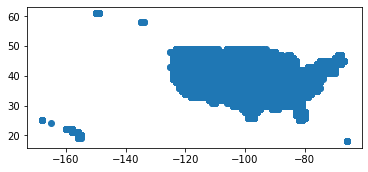

In [59]:
covid19_1.plot()

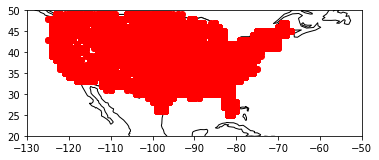

In [67]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
ax.set(xlim=(-130, -50), ylim=(20, 50))
# We can now plot our ``GeoDataFrame``.
covid19_1.plot(ax=ax, color='red')

plt.show()

In [61]:
county = pd.read_csv('Characters..csv')

In [62]:

county

,Primary Strata,Primary Strata Name,Secondary Strata,Secondary Strata Name,Count,Percent
0,Age,18-49 yr,Sex,Male,4840.0,50.5
1,Age,18-49 yr,Sex,Female,4748.0,49.5
2,Age,18-49 yr,Race/Ethnicity,White,1386.0,15.5
3,Age,18-49 yr,Race/Ethnicity,Black,2625.0,29.4
4,Age,18-49 yr,Race/Ethnicity,Hispanic/Latino,3682.0,41.2
...,...,...,...,...,...,...
1905,Mechanical ventilation,No,Race/Ethnicity,Black,1959.0,28.4
1906,Mechanical ventilation,No,Race/Ethnicity,Hispanic/Latino,1208.0,17.5
1907,Mechanical ventilation,No,Race/Ethnicity,Asian/Pacific Islander,454.0,6.6
1908,Mechanical ventilation,No,Race/Ethnicity,American Indian/Alaska Native,123.0,1.8


In [63]:
county.sort_values('Count', ascending = False)



,Primary Strata,Primary Strata Name,Secondary Strata,Secondary Strata Name,Count,Percent
465,Age,Overall,Sex,Male,17727.0,51.6
466,Age,Overall,Sex,Female,16628.0,48.4
468,Age,Overall,Race/Ethnicity,Black,10576.0,32.7
467,Age,Overall,Race/Ethnicity,White,10513.0,32.5
547,Age,Overall,Conjunctivitis,No,9211.0,99.8
...,...,...,...,...,...,...
1824,Race/Ethnicity,Other,Disseminated intravascular coagulation,Yes,NaN,NaN
1826,Race/Ethnicity,Other,Guillan-Barre syndrome,Yes,NaN,NaN
1828,Race/Ethnicity,Other,Hemophagocytic syndrome,Yes,NaN,NaN
1830,Race/Ethnicity,Other,Invasive pulmonary aspergillosis,Yes,NaN,NaN


In [76]:
contents = gpd.read_file('new-york-counties.geojson')

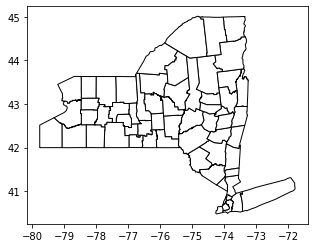

In [79]:
ax = contents.plot(color='white', edgecolor='black')

/opt/conda/lib/python3.7/site-packages/contextily/tile.py:629: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


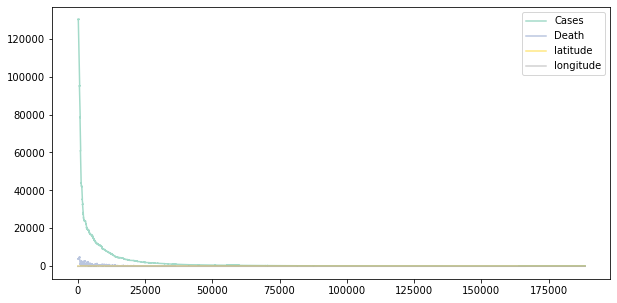

In [82]:
covid19.plot(figsize=(10,5), alpha=0.6, cmap='Set2')
# now we add a basemap. ctx finds a basemap for a background from
# an online repository
ctx.add_basemap(ax)